In [1]:
import pandas as pd
import numpy as np
import requests
import os
import time
import tweepy
import matplotlib.pyplot as plt
import json
import seaborn as sns
% matplotlib inline

pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

In [2]:
#retrieving the image prediction tsv file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image-predictions.tsv',mode='wb') as f:
        f.write(response.content)

In [3]:
#Reading files using Pandas DataFrame
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

In [4]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [5]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
#Creating API object with Twitter keys
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [7]:
tweet_ids = twitter_archive['tweet_id']

# creating a list for tweets with exceptions/errors 
tweet_errors= []

# List of tweets
tweet_df = []

# start time of execution
start = time.time()

# For loop which will add each available tweet json to df_list
for tweet_id in tweet_ids:
    try:
        tweet = api.get_status(tweet_id, tweet_mode= 'extended')._json 
        
        favorite_counts = tweet['favorite_count']
        retweet_counts = tweet['retweet_count']
        follower_counts = tweet['user']['followers_count']
        friend_counts = tweet['user']['friends_count']
        status_counts = tweet['user']['statuses_count']
        language = tweet['lang']
        date_time = tweet['created_at']
        tweet_df.append({'tweet_id': int(tweet_id),
                         'favorite_counts': int(favorite_counts),
                         'retweet_counts': int(retweet_counts),
                         'follower_counts': int(follower_counts),
                         'friend_counts' :int(friend_counts),
                         'status_counts' : int(status_counts),
                         'language' : str(language),
                         'date_time': pd.to_datetime(date_time)})
    except Exception as e:
        print(str(tweet_id)+ " " + str(e))
        tweet_errors.append(tweet_id)
        
# end time for excution
end = time.time()

#printing time for execution
print("Total time taken for this process", end - start)

888202515573088257 [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560 [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 [{'code': 144, 'message': 'No status found with that ID.'}]
837366284874571778 [{'code': 144, 'message': 'No sta

In [8]:
len(tweet_df[1])

8

In [9]:
#Creating the DataFrame, saving the JSON file to csv and reading it
tweet_df_json = pd.DataFrame(tweet_df, columns = ['tweet_id','favorite_counts','retweet_counts','follower_counts','friend_counts','status_counts','language','date_time'])
tweet_df_json.to_csv('tweet_json.txt',encoding='utf-8', index=False)
api_df = pd.read_csv('tweet_json.txt', encoding='utf-8')                        

In [10]:
api_df.head()

,tweet_id,favorite_counts,retweet_counts,follower_counts,friend_counts,status_counts,language,date_time
0,892420643555336193,35942,7635,8794505,17,12474,en,2017-08-01 16:23:56
1,892177421306343426,31023,5644,8794505,17,12474,en,2017-08-01 00:17:27
2,891815181378084864,23342,3741,8794505,17,12474,en,2017-07-31 00:18:03
3,891689557279858688,39237,7807,8794505,17,12474,en,2017-07-30 15:58:51
4,891327558926688256,37472,8400,8794505,17,12474,en,2017-07-29 16:00:24


In [11]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [13]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [15]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
tweet_id           2331 non-null int64
favorite_counts    2331 non-null int64
retweet_counts     2331 non-null int64
follower_counts    2331 non-null int64
friend_counts      2331 non-null int64
status_counts      2331 non-null int64
language           2331 non-null object
date_time          2331 non-null object
dtypes: int64(6), object(2)
memory usage: 145.8+ KB


In [16]:
api_df

,tweet_id,favorite_counts,retweet_counts,follower_counts,friend_counts,status_counts,language,date_time
0,892420643555336193,35942,7635,8794505,17,12474,en,2017-08-01 16:23:56
1,892177421306343426,31023,5644,8794505,17,12474,en,2017-08-01 00:17:27
2,891815181378084864,23342,3741,8794505,17,12474,en,2017-07-31 00:18:03
3,891689557279858688,39237,7807,8794505,17,12474,en,2017-07-30 15:58:51
4,891327558926688256,37472,8400,8794505,17,12474,en,2017-07-29 16:00:24
5,891087950875897856,18889,2818,8794505,17,12474,en,2017-07-29 00:08:17
6,890971913173991426,10972,1835,8794505,17,12474,en,2017-07-28 16:27:12
7,890729181411237888,60571,17043,8794505,17,12474,en,2017-07-28 00:22:40
8,890609185150312448,25981,3880,8794505,17,12474,en,2017-07-27 16:25:51
9,890240255349198849,29692,6637,8794505,17,12474,en,2017-07-26 15:59:51


## Quality Issues

1. All 3 DataFrames can be merged into a single DataFrame.
2. Timestamps can be changed into datetime datatype.
3. Check for and adjust erroneous rating numerators and denominators.
4. Remove columns that are irrelevant information or contains too little information.
5. Change p1, p2, and p3 into categorical data type.
6. Dog names contain errors that are not names.
8. Replaces all Null values with "None" across all columns.
10. the friend_counts, follower_counts, and status_counts column data looks incorrect.

## Tidiness Issues

9. Dog breed image predictions do not have uniform letter casing.
7. There are 4 dog life stage columns can be replaced with a single column.

## Data Cleaning

In [17]:
#copy dataframes
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
api_df_clean = api_df.copy()

### Define

1. All 3 DataFrames can be merged into a single DataFrame.

### Code

In [18]:
combined_df_clean = pd.merge(twitter_archive_clean, image_predictions_clean, on='tweet_id', how='inner')
combined_df_clean = pd.merge(combined_df_clean, api_df_clean, on='tweet_id', how='inner')

### Test

In [19]:
combined_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 35 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                       20

### Define

2. Timestamp change into datetime data type.

### Code

In [20]:
combined_df_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

### Test

In [21]:
combined_df_clean['timestamp'].dtype

dtype('<M8[ns]')

### Define

3. The denominators aren't consistent, the project overview page stated that WeRateDogs always had a rating denominator of 10. Although they said the usually rate the dogs over the score of 10 for the numerator, some of the numbers just don't make sense.

### Code

In [22]:
combined_df_clean['rating_denominator'].value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [23]:
scan1 = combined_df_clean.rating_denominator != 10

scan_cols = ['text', 'rating_numerator', 'rating_denominator']
cleanup1 = combined_df_clean[scan1][scan_cols]
cleanup1

,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


It appears that most of the entries with the wrong numerator are either typos or rating groups of dogs. To avoid confusion, I'll replace the entries with multiple settings and typos with 'None'. The rest listed below will be adjusted accordingly.

1068(14/10), 1202(11/10), 1662(10/10), 2335(9/10)

In [24]:
## Changing index number 1068
combined_df_clean.ix[1068,'rating_numerator'] = 14
combined_df_clean.ix[1068, 'rating_denominator'] = 10

## Changing index number 1202
combined_df_clean.ix[1202,'rating_numerator'] = 11
combined_df_clean.ix[1202, 'rating_denominator'] = 10

## Changing index number 1662
combined_df_clean.ix[1662,'rating_numerator'] = 10
combined_df_clean.ix[1662, 'rating_denominator'] = 10

## Changing index number 2335
combined_df_clean.ix[2335,'rating_numerator'] = 9
combined_df_clean.ix[2335, 'rating_denominator'] = 10

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/opt/conda/lib/python3.6/site-packages/ipy

In [25]:
for number in cleanup1.index:
    if number in [1068, 1202, 1662, 2335]:
        continue
    else:
        combined_df_clean.ix[number,'rating_numerator'] = 'None'
        combined_df_clean.ix[number, 'rating_denominator'] = 'None'
combined_df_clean[scan1][scan_cols]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",None,None
342,@docmisterio account started on 11/15/15,None,None
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,None,None
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,None,None
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",None,None
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,None,None
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14,10
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,None,None
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,None,None
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11,10


In [26]:
combined_df_clean['rating_numerator'].value_counts()

12      558
11      464
10      462
13      351
9       157
8       102
14      55 
7       54 
5       37 
6       32 
3       19 
None    19 
4       15 
2       9  
1       8  
0       2  
15      2  
75      2  
420     2  
17      1  
26      1  
27      1  
666     1  
182     1  
1776    1  
Name: rating_numerator, dtype: int64

In [27]:
## Since there are many scores above 10, I'll check for numbers above 20
pre_scan2 = combined_df_clean.query('rating_numerator != "None"')
scan2 = pre_scan2.query('rating_numerator >= 20')

cleanup2 = scan2[scan_cols]
cleanup2

,text,rating_numerator,rating_denominator
188,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420,10
189,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666,10
290,@markhoppus 182/10,182,10
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10
2074,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10


So it looks like some large values are legitimate, the owners just like their dog(s) too much. Others are retweets, so they don't count. I'll be changing the ones that are erroneous to none or values that need to be adjusted to what the owners intentionally wanted stated in the texts.

change: 695(9.75/10), 763(11.27), 1712(11.26/10), 2074(420/10)

keep: 979

In [28]:
## Changing index number 695
combined_df_clean.ix[695,'rating_numerator'] = 9.75

## Changing index number 763
combined_df_clean.ix[763,'rating_numerator'] = 11.27

## Changing index number 1712
combined_df_clean.ix[1712,'rating_numerator'] = 11.26

## Changing index number 2074
combined_df_clean.ix[2074,'rating_numerator'] = 420

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.l

In [29]:
## set all other numerators and denominators in cleanup2 to "None"
for number in cleanup2.index:
    if number in [695, 979, 763, 1712, 2074]:
        continue
    else:
        combined_df_clean.ix[number,'rating_numerator'] = 'None'
        combined_df_clean.ix[number, 'rating_denominator'] = 'None'
pre_scan2 = combined_df_clean.query('rating_numerator != "None"')
scan2 = pre_scan2.query('rating_numerator >= 20')
scan2[scan_cols]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


,text,rating_numerator,rating_denominator
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
2074,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10


### Test

In [30]:
combined_df_clean['rating_denominator'].value_counts()

10      2333
None    23  
Name: rating_denominator, dtype: int64

In [31]:
combined_df_clean['rating_numerator'].value_counts()

12       558
11       464
10       462
13       351
9        157
8        102
14       55 
7        54 
5        37 
6        32 
None     23 
3        19 
4        15 
2        9  
1        8  
0        2  
15       2  
17       1  
9.75     1  
11.27    1  
420      1  
11.26    1  
1776     1  
Name: rating_numerator, dtype: int64

### Define

4. Some columns are unnecessary. in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp seves no real purpose. The date_time column extracted from twitter api is redundant.

### Code

In [32]:
combined_df_clean = combined_df_clean.drop('in_reply_to_status_id',axis=1)
combined_df_clean = combined_df_clean.drop('in_reply_to_user_id',axis=1)
combined_df_clean = combined_df_clean.drop('retweeted_status_id',axis=1)
combined_df_clean = combined_df_clean.drop('retweeted_status_user_id',axis=1)
combined_df_clean = combined_df_clean.drop('retweeted_status_timestamp',axis=1)
combined_df_clean = combined_df_clean.drop('date_time', axis=1)

### Test

In [33]:
combined_df_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog',
       'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorite_counts',
       'retweet_counts', 'follower_counts', 'friend_counts', 'status_counts',
       'language'],
      dtype='object')

### Define

5. Change p1, p2, and p3 into categorical data type.

### Code

In [34]:
combined_df_clean[['p1', 'p2', 'p3']].astype('category')

,p1,p2,p3
0,orange,bagel,banana
1,Chihuahua,Pekinese,papillon
2,Chihuahua,malamute,kelpie
3,paper_towel,Labrador_retriever,spatula
4,basset,English_springer,German_short-haired_pointer
5,Chesapeake_Bay_retriever,Irish_terrier,Indian_elephant
6,Appenzeller,Border_collie,ice_lolly
7,Pomeranian,Eskimo_dog,Pembroke
8,Irish_terrier,Irish_setter,Chesapeake_Bay_retriever
9,Pembroke,Cardigan,Chihuahua


### Test

In [35]:
print(combined_df_clean['p1'].dtype, combined_df_clean['p2'].dtype, combined_df_clean['p3'].dtype)

object object object


### Define

6. Some dog names are erroneous. Some values in the name column are just words that appear in the text of the tweet and doesn't reflect the dog's actual name.

### Code

In [36]:
sorted(combined_df_clean['name'], reverse=True)

['very',
 'very',
 'very',
 'very',
 'very',
 'unacceptable',
 'this',
 'the',
 'the',
 'the',
 'the',
 'the',
 'the',
 'the',
 'the',
 'such',
 'space',
 'quite',
 'quite',
 'quite',
 'quite',
 'one',
 'one',
 'one',
 'one',
 'old',
 'officially',
 'not',
 'not',
 'my',
 'mad',
 'mad',
 'light',
 'life',
 'just',
 'just',
 'just',
 'just',
 'infuriating',
 'incredibly',
 'his',
 'getting',
 'getting',
 'by',
 'an',
 'an',
 'an',
 'an',
 'an',
 'an',
 'an',
 'all',
 'actually',
 'actually',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'Zuzu',
 'Zooey',
 'Zoey',
 'Zoey',
 'Zoey',
 'Zoe',
 'Ziva',
 'Zeus',
 'Zeke',
 'Zeke',
 'Zeke',
 'Zeek',
 'Zara',
 'Yukon',
 'Yogi',
 'Yogi',
 'Yoda',
 'Wyatt',
 'Wyatt',


In [37]:
ab = combined_df_clean['name'].str.extract(r'(^[A-ZÀ-ÿ][A-Za-zÀ-ÖØ-öø-ÿ]{0,}$)', expand=True)

print(ab[0].values)

['Phineas' 'Tilly' 'Archie' ..., nan nan 'None']


In [38]:
real_names = []
no_names = []
error_names = []

for name in combined_df_clean['name']:
    if name == "None":
        no_names.append(name)
    elif name in ab[0].values:
        real_names.append(name)
    else:
        error_names.append(name)

In [39]:
error_names

['such',
 'a',
 'quite',
 'quite',
 'quite',
 'not',
 'one',
 'incredibly',
 'a',
 'mad',
 'an',
 'very',
 'a',
 'very',
 'just',
 'my',
 'one',
 'not',
 'his',
 'one',
 'a',
 'a',
 'a',
 'an',
 'very',
 'actually',
 'a',
 'just',
 'getting',
 'mad',
 'very',
 'this',
 'unacceptable',
 'all',
 'a',
 'old',
 'a',
 'infuriating',
 'a',
 'a',
 'a',
 'an',
 'a',
 'a',
 'very',
 'getting',
 'just',
 'a',
 'the',
 'the',
 'actually',
 'by',
 'a',
 'officially',
 'a',
 'the',
 'the',
 'a',
 'a',
 'a',
 'a',
 'life',
 'a',
 'one',
 'a',
 'a',
 'a',
 'light',
 'just',
 'space',
 'a',
 'the',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'an',
 'a',
 'the',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'quite',
 'a',
 'an',
 'a',
 'an',
 'the',
 'the',
 'a',
 'a',
 'an',
 'a',
 'a',
 'a',
 'a']

In [40]:
name_list = combined_df_clean['name']

for name in name_list:
    if name in error_names:
        name_list = name_list.replace(name, 'None')
    else:
        continue

In [41]:
combined_df_clean['name'] = name_list

## Test

In [42]:
combined_df_clean['name'].value_counts()

None         854
Charlie      12 
Lucy         11 
Oliver       11 
Cooper       11 
Tucker       10 
Penny        10 
Lola         10 
Bo           9  
Winston      9  
Sadie        8  
Toby         7  
Buddy        7  
Bailey       7  
Daisy        7  
Scout        6  
Rusty        6  
Jax          6  
Koda         6  
Stanley      6  
Oscar        6  
Leo          6  
Dave         6  
Jack         6  
Milo         6  
Bella        6  
Alfie        5  
George       5  
Chester      5  
Phil         5  
            ..  
Lulu         1  
Vince        1  
Mutt         1  
Zoe          1  
Lupe         1  
Izzy         1  
Fletcher     1  
Marlee       1  
Norman       1  
Coopson      1  
Rilo         1  
Iroh         1  
Emanuel      1  
Anna         1  
Dido         1  
Nimbus       1  
Stewie       1  
Comet        1  
Ruffles      1  
Rhino        1  
Beebop       1  
Fabio        1  
Bookstore    1  
Clifford     1  
Wesley       1  
Stark        1  
Koko         1  
Sandra       1

## Define

7.  twitter_archive the 4 dog category columns can be replaced with a single column.

## Code

In [67]:
melt_columns = ['doggo', 'floofer', 'pupper', 'puppo']
stay_columns = []

for column in combined_df_clean.columns:
    if column not in melt_columns:
        stay_columns.append(column)
    else:
        continue

stay_columns

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'favorite_counts',
 'retweet_counts',
 'follower_counts',
 'friend_counts',
 'status_counts',
 'language',
 'dog_stages']

In [68]:
combined_df_clean = pd.melt(combined_df_clean,
                            id_vars = stay_columns,
                            value_vars = melt_columns,
                            var_name = 'dog_stages',
                            value_name = 'stage')

combined_df_clean = combined_df_clean.drop('stage',axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


## Test

In [45]:
combined_df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,p3,p3_conf,p3_dog,favorite_counts,retweet_counts,follower_counts,friend_counts,status_counts,language,dog_stages
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,...,banana,0.076110,False,35942.0,7635.0,8794505.0,17.0,12474.0,en,doggo
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,...,papillon,0.068957,True,31023.0,5644.0,8794505.0,17.0,12474.0,en,doggo
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,...,kelpie,0.031379,True,23342.0,3741.0,8794505.0,17.0,12474.0,en,doggo
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,...,spatula,0.040836,False,39237.0,7807.0,8794505.0,17.0,12474.0,en,doggo
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,...,German_short-haired_pointer,0.175219,True,37472.0,8400.0,8794505.0,17.0,12474.0,en,doggo


## Define

8. Find and change the "Null" values across all columns to None.

## Code

In [46]:
for column in combined_df_clean:
    if combined_df_clean[column].values == None:
        column.replace('NaN', 'None')
    else:
        continue

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


## Test

In [47]:
check_list = []
for column in combined_df_clean:
    if combined_df_clean[column].values == None:
        check_list.append(column)
    else:
        continue
check_list

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


[]

## Define

9. dog breed image predictions(columns p1, p2, p3) do not have uniform letter casing.

## Code

In [48]:
combined_df_clean['p1'] = combined_df_clean['p1'].str.lower()
combined_df_clean['p2'] = combined_df_clean['p2'].str.lower()
combined_df_clean['p3'] = combined_df_clean['p3'].str.lower()

## Test

In [49]:
combined_df_clean['p1'].value_counts()

golden_retriever             750
labrador_retriever           500
pembroke                     445
chihuahua                    415
pug                          285
chow                         220
samoyed                      215
toy_poodle                   195
pomeranian                   190
cocker_spaniel               150
malamute                     150
french_bulldog               130
miniature_pinscher           115
chesapeake_bay_retriever     115
seat_belt                    110
german_shepherd              100
siberian_husky               100
staffordshire_bullterrier    100
cardigan                     95 
web_site                     95 
teddy                        90 
shetland_sheepdog            90 
beagle                       90 
eskimo_dog                   90 
maltese_dog                  90 
shih-tzu                     85 
rottweiler                   85 
lakeland_terrier             85 
kuvasz                       80 
italian_greyhound            80 
          

In [50]:
combined_df_clean['p2'].value_counts()

labrador_retriever                520
golden_retriever                  460
cardigan                          370
chihuahua                         220
pomeranian                        210
chesapeake_bay_retriever          205
french_bulldog                    205
toy_poodle                        185
cocker_spaniel                    170
siberian_husky                    165
miniature_poodle                  165
beagle                            140
pembroke                          135
collie                            135
eskimo_dog                        135
kuvasz                            130
italian_greyhound                 110
pekinese                          105
american_staffordshire_terrier    105
malinois                          100
samoyed                           100
chow                              100
toy_terrier                       100
miniature_pinscher                100
norwegian_elkhound                95 
boston_bull                       95 
staffordshir

In [51]:
combined_df_clean['p3'].value_counts()

labrador_retriever                395
chihuahua                         290
golden_retriever                  240
eskimo_dog                        190
kelpie                            175
kuvasz                            170
chow                              160
staffordshire_bullterrier         160
cocker_spaniel                    155
beagle                            155
pekinese                          145
pomeranian                        145
toy_poodle                        145
great_pyrenees                    135
pembroke                          135
chesapeake_bay_retriever          135
malamute                          130
french_bulldog                    130
american_staffordshire_terrier    120
cardigan                          115
pug                               115
basenji                           105
toy_terrier                       100
bull_mastiff                      100
siberian_husky                    95 
boston_bull                       85 
shetland_she

## Define

10. the friend_counts, follower_counts, and status_counts column data looks incorrect.

## Code

In [52]:
combined_df_clean['status_counts'].value_counts()

12474.0    11655
Name: status_counts, dtype: int64

In [53]:
combined_df_clean['follower_counts'].value_counts()

8794505.0    3055
8794403.0    2280
8794392.0    1505
8794506.0    1305
8794393.0    1300
8794391.0    1085
8794402.0    460 
8794390.0    210 
8794394.0    195 
8794395.0    140 
8795068.0    35  
8795057.0    20  
8795049.0    20  
8795058.0    15  
8795056.0    10  
8795055.0    10  
8795067.0    5   
8795050.0    5   
Name: follower_counts, dtype: int64

In [54]:
combined_df_clean['friend_counts'].value_counts()

17.0    11655
Name: friend_counts, dtype: int64

In [55]:
## Since the error either came from the Twitter API originally or we scraped the wrong 
## information. It's best to drop these tables since they're additional information.
combined_df_clean.drop('status_counts', axis =1)
combined_df_clean.drop('follower_counts', axis =1)
combined_df_clean.drop('friend_counts', axis =1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,p2_dog,p3,p3_conf,p3_dog,favorite_counts,retweet_counts,follower_counts,status_counts,language,dog_stages
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,...,False,banana,0.076110,False,35942.0,7635.0,8794505.0,12474.0,en,doggo
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,...,True,papillon,0.068957,True,31023.0,5644.0,8794505.0,12474.0,en,doggo
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,...,True,kelpie,0.031379,True,23342.0,3741.0,8794505.0,12474.0,en,doggo
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,...,True,spatula,0.040836,False,39237.0,7807.0,8794505.0,12474.0,en,doggo
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,...,True,german_short-haired_pointer,0.175219,True,37472.0,8400.0,8794505.0,12474.0,en,doggo
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,...,True,indian_elephant,0.076902,False,18889.0,2818.0,8794505.0,12474.0,en,doggo
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1.0,...,True,ice_lolly,0.193548,False,10972.0,1835.0,8794505.0,12474.0,en,doggo
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_r

## Test

In [56]:
combined_df_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'favorite_counts', 'retweet_counts', 'follower_counts',
       'friend_counts', 'status_counts', 'language', 'dog_stages'],
      dtype='object')

In [57]:
float(combined_df_clean.query('dog_stages == "doggo"')['dog_stages'].count())

2356.0

## Visualizations

Distribution of Dog Life Stages

In [58]:
labels = combined_df_clean[combined_df_clean['dog_stages'] != 'None']['dog_stages'].value_counts().index.tolist()[0:4]
sizes = list(combined_df_clean[combined_df_clean['dog_stages'] != 'None']['dog_stages'].value_counts())[0:4]
explode = (0,0,0,0)

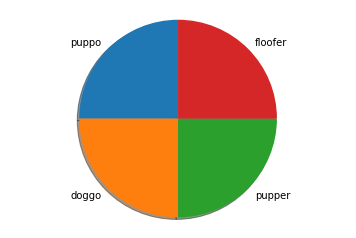

In [59]:
fig1, axis1 = plt.subplots()
axis1.pie(sizes, explode = explode, labels = labels, shadow = True, startangle = 90)
axis1.axis('equal')

plt.show()

In [71]:
sizes

[2356, 2356, 2356, 2356]

In [60]:
combined_df_clean['name'].value_counts()

None         4270
Charlie      60  
Cooper       55  
Oliver       55  
Lucy         55  
Penny        50  
Lola         50  
Tucker       50  
Bo           45  
Winston      45  
Sadie        40  
Daisy        35  
Toby         35  
Bailey       35  
Buddy        35  
Leo          30  
Rusty        30  
Bella        30  
Koda         30  
Milo         30  
Dave         30  
Oscar        30  
Jax          30  
Scout        30  
Stanley      30  
Jack         30  
Larry        25  
Sammy        25  
Finn         25  
Louis        25  
             ..  
Ralph        5   
Flash        5   
Berkeley     5   
Clybe        5   
Rover        5   
Fynn         5   
Beckham      5   
Durg         5   
Ozzie        5   
Blu          5   
Ruffles      5   
Beebop       5   
Darby        5   
Bookstore    5   
Clifford     5   
Wesley       5   
Stark        5   
Koko         5   
Sandra       5   
Rhino        5   
Fletcher     5   
Benny        5   
Izzy         5   
Lizzie       5   
Ralpher   

Top 10 Most Popular Names for Dogs By Tweets

In [61]:
core = combined_df_clean[combined_df_clean['name'] != "None"].name.value_counts()[0:10]

In [62]:
dog_names = core.index
tweet_number = core

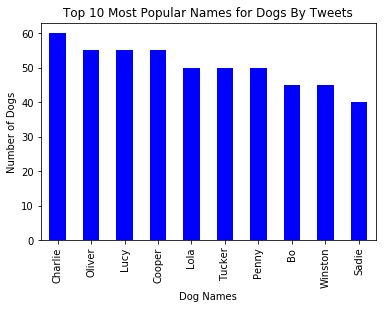

In [63]:
fig, ax = plt.subplots()
core.plot(kind='bar', x=dog_names, y=tweet_number, ax=ax, color='blue')
plt.title('Top 10 Most Popular Names for Dogs By Tweets')
plt.xlabel('Dog Names')
plt.ylabel('Number of Dogs')
plt.show()

Correlation Between Favorites and Retweets

Text(0.5,1,'Correlation Between Favorites and Retweets')

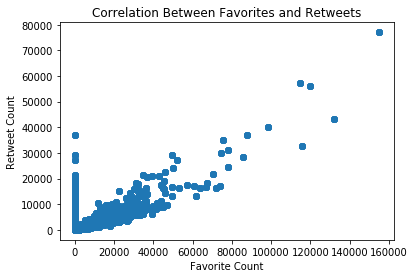

In [66]:
fav = combined_df_clean['favorite_counts']
retw = combined_df_clean['retweet_counts']

plt.scatter(fav, retw)
plt.xlabel('Favorite Count')
plt.ylabel('Retweet Count')
plt.title('Correlation Between Favorites and Retweets')